In [2]:
import os
import openai
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API key
openai.api_key = os.getenv("OPENAI_API_KEY")

Running 10 simulations for each of the 2 personas...
Running 10 simulations for Compliance Officer - Large Tech...
  - Simulation 1/10
  - Simulation 2/10
  - Simulation 3/10
  - Simulation 4/10
  - Simulation 5/10
  - Simulation 6/10
  - Simulation 7/10
  - Simulation 8/10
  - Simulation 9/10
  - Simulation 10/10
Running 10 simulations for Small Business Owner...
  - Simulation 1/10
  - Simulation 2/10
  - Simulation 3/10
  - Simulation 4/10
  - Simulation 5/10
  - Simulation 6/10
  - Simulation 7/10
  - Simulation 8/10
  - Simulation 9/10
  - Simulation 10/10
Estimates saved to compliance_estimates_A6453_20250505_155120.csv
Subtask comparison saved to subtask_comparison_A6453_20250505_155120.csv
Persona statistics saved to persona_stats_A6453_20250505_155120.csv
Error generating visualizations: No module named 'seaborn'
Compliance variance analysis saved to compliance_variance_A6453_20250505_155120.csv
Variance visualization saved to compliance_variance_A6453_20250505_155120.png
Deta

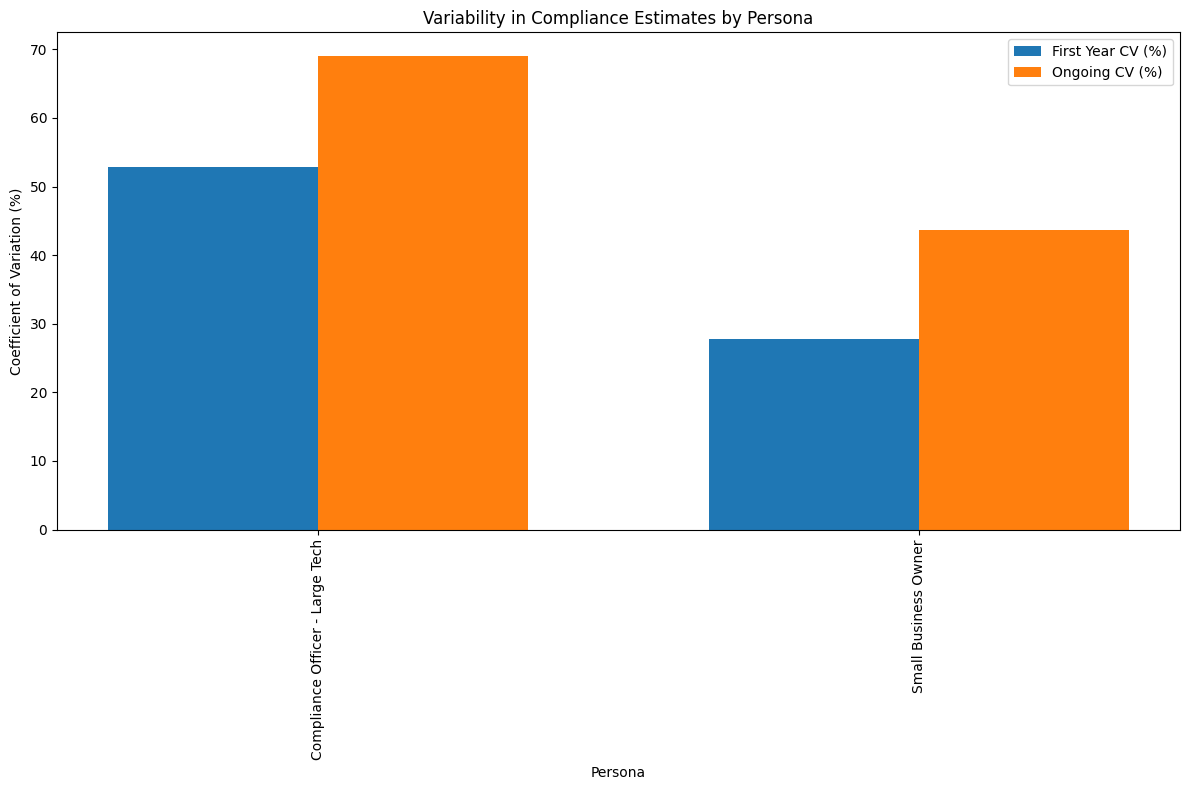

In [2]:
import fitz  # PyMuPDF
import json
import os
import openai
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os.path
from datetime import datetime

# Load environment variables from .env file
load_dotenv()

# Constants
PERSONAS = [
    {
        "name": "Compliance Officer - Large Tech",
        "industry": "Technology",
        "resources": "High",
        "legal_team": "In-house counsel + external",
        "familiarity": "High"
    },
    {
        "name": "Small Business Owner",
        "industry": "Retail",
        "resources": "Low",
        "legal_team": "None",
        "familiarity": "Low"
    }
]

# Enhanced template with specific subtask requirements
PROMPT_TEMPLATE = """
You are simulating the behavior of a {persona_name} working in the {industry} sector.
They have {resources} resources and their legal team is: {legal_team}. Their familiarity with regulatory compliance is: {familiarity}.

Given the regulation text below, estimate the following:
1. Break down the compliance process into specific subtasks
2. Estimate hours required for each subtask (both first-year and ongoing)
3. Identify key dependencies between subtasks
4. Flag subtasks that may require specialized expertise

Regulation text:
\"\"\"{regulation_excerpt}\"\"\"

Structure your response as JSON with the following schema:
{{
  "persona": "{persona_name}",
  "first_year_total_hours": <number>,
  "annual_ongoing_hours": <number>,
  "subtasks": [
    {{
      "id": "task1",
      "name": "Task name",
      "description": "Brief description of what this task involves",
      "first_year_hours": <number>,
      "ongoing_annual_hours": <number>,
      "requires_expertise": ["legal", "technical", "hr", etc.],
      "dependencies": ["task3", "task5"],
      "risk_level": "high/medium/low",
      "notes": "Any specific considerations for this persona"
    }},
    ...
  ],
  "key_risks": [
    "Risk description 1",
    "Risk description 2"
  ],
  "confidence_level": "high/medium/low"
}}

Ensure the subtasks are meaningful, specific, and appropriate for the regulation requirements.
{simulation_instruction}
"""

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    return "\n".join(page.get_text() for page in doc)

def create_prompt(persona, excerpt, simulation_number):
    # Add slight variation instruction for each simulation
    simulation_instruction = f"""
This is simulation #{simulation_number} of 10. Use your judgment to introduce realistic variability in the estimates, 
while maintaining consistency with the persona's characteristics and the regulation requirements.
"""
    
    return PROMPT_TEMPLATE.format(
        persona_name=persona["name"],
        industry=persona["industry"],
        resources=persona["resources"],
        legal_team=persona["legal_team"],
        familiarity=persona["familiarity"],
        regulation_excerpt=excerpt[:3000],  # truncate if too long
        simulation_instruction=simulation_instruction
    )

def query_openai(prompt, model="o4 mini"):
    # Updated to use the new OpenAI API format (>=1.0.0)
    openai.api_key = os.getenv("OPENAI_API_KEY")
    
    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5  # Slightly higher temperature for more variation
    )
    
    return response.choices[0].message.content

def simulate_all_personas(reg_text, num_simulations=10):
    all_results = []
    
    # Create a timestamp for this batch of simulations
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for persona in PERSONAS:
        persona_results = []
        print(f"Running {num_simulations} simulations for {persona['name']}...")
        
        for sim_num in range(1, num_simulations + 1):
            prompt = create_prompt(persona, reg_text, sim_num)
            try:
                print(f"  - Simulation {sim_num}/{num_simulations}")
                raw_output = query_openai(prompt)
                json_output = json.loads(raw_output)
                
                # Add simulation number to the output
                json_output["simulation_number"] = sim_num
                
                persona_results.append(json_output)
            except Exception as e:
                error_result = {
                    "persona": persona["name"], 
                    "simulation_number": sim_num,
                    "error": str(e)
                }
                persona_results.append(error_result)
                print(f"    Error: {str(e)}")
        
        # Save individual persona results
        with open(f"persona_{persona['name'].replace(' ', '_').lower()}_{timestamp}.json", "w") as f:
            json.dump(persona_results, f, indent=2)
        
        all_results.extend(persona_results)
    
    return all_results

def generate_subtask_report(outputs, base_filename):
    """Generate a comprehensive report comparing subtasks across personas and simulations"""
    # Create a DataFrame for better analysis
    all_subtasks = []
    
    for output in outputs:
        if "subtasks" in output:
            persona = output["persona"]
            sim_num = output.get("simulation_number", 1)
            
            for task in output["subtasks"]:
                task_copy = task.copy()
                task_copy["persona"] = persona
                task_copy["simulation_number"] = sim_num
                all_subtasks.append(task_copy)
    
    if not all_subtasks:
        print("No valid subtasks found in the output!")
        return
        
    subtask_df = pd.DataFrame(all_subtasks)
    
    # Generate basic statistics
    subtask_summary = subtask_df.groupby(["name", "persona"]).agg({
        "first_year_hours": ["mean", "std", "min", "max"],
        "ongoing_annual_hours": ["mean", "std", "min", "max"]
    }).reset_index()
    
    subtask_summary.to_csv(f"subtask_comparison_{base_filename}.csv", index=False)
    print(f"Subtask comparison saved to subtask_comparison_{base_filename}.csv")
    
    # Generate per-persona statistics
    persona_summary = subtask_df.groupby(["persona", "simulation_number"]).agg({
        "first_year_hours": "sum",
        "ongoing_annual_hours": "sum"
    }).reset_index()
    
    persona_stats = persona_summary.groupby("persona").agg({
        "first_year_hours": ["mean", "std", "min", "max"],
        "ongoing_annual_hours": ["mean", "std", "min", "max"]
    }).reset_index()
    
    persona_stats.to_csv(f"persona_stats_{base_filename}.csv", index=False)
    print(f"Persona statistics saved to persona_stats_{base_filename}.csv")
    
    # Create a visualization of the results
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(12, 8))
        
        # Plot first year hours by persona
        sns.boxplot(x="persona", y="first_year_hours", data=persona_summary)
        plt.title("Distribution of First Year Hours by Persona")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f"first_year_hours_{base_filename}.png")
        
        plt.figure(figsize=(12, 8))
        
        # Plot ongoing annual hours by persona
        sns.boxplot(x="persona", y="ongoing_annual_hours", data=persona_summary)
        plt.title("Distribution of Ongoing Annual Hours by Persona")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f"ongoing_hours_{base_filename}.png")
        
        print(f"Visualizations saved to first_year_hours_{base_filename}.png and ongoing_hours_{base_filename}.png")
        
    except Exception as e:
        print(f"Error generating visualizations: {str(e)}")

def get_base_filename(pdf_path):
    """Extract the base filename without extension from the PDF path"""
    # Get just the filename without the directory path
    filename = os.path.basename(pdf_path)
    # Remove the extension
    base_filename = os.path.splitext(filename)[0]
    return base_filename

def analyze_compliance_variance(outputs, base_filename):
    """Analyze variance in compliance estimates across simulations"""
    # Extract first_year_total_hours and annual_ongoing_hours for each persona and simulation
    compliance_data = []
    
    for output in outputs:
        if "first_year_total_hours" in output and "annual_ongoing_hours" in output:
            compliance_data.append({
                "persona": output["persona"],
                "simulation_number": output.get("simulation_number", 1),
                "first_year_total_hours": output["first_year_total_hours"],
                "annual_ongoing_hours": output["annual_ongoing_hours"],
                "confidence_level": output.get("confidence_level", "unknown")
            })
    
    if not compliance_data:
        print("No valid compliance data found!")
        return
        
    df = pd.DataFrame(compliance_data)
    
    # Calculate coefficient of variation for each persona
    cv_data = []
    for persona in df["persona"].unique():
        persona_df = df[df["persona"] == persona]
        
        first_year_mean = persona_df["first_year_total_hours"].mean()
        first_year_std = persona_df["first_year_total_hours"].std()
        first_year_cv = (first_year_std / first_year_mean) * 100 if first_year_mean > 0 else 0
        
        ongoing_mean = persona_df["annual_ongoing_hours"].mean()
        ongoing_std = persona_df["annual_ongoing_hours"].std()
        ongoing_cv = (ongoing_std / ongoing_mean) * 100 if ongoing_mean > 0 else 0
        
        cv_data.append({
            "persona": persona,
            "first_year_mean": first_year_mean,
            "first_year_std": first_year_std,
            "first_year_cv": first_year_cv,
            "ongoing_mean": ongoing_mean,
            "ongoing_std": ongoing_std,
            "ongoing_cv": ongoing_cv,
            "confidence_level_mode": persona_df["confidence_level"].mode()[0] if not persona_df["confidence_level"].empty else "unknown"
        })
    
    cv_df = pd.DataFrame(cv_data)
    cv_df.to_csv(f"compliance_variance_{base_filename}.csv", index=False)
    print(f"Compliance variance analysis saved to compliance_variance_{base_filename}.csv")
    
    # Plot coefficient of variation
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 8))
        
        x = range(len(cv_df))
        width = 0.35
        
        plt.bar([i - width/2 for i in x], cv_df["first_year_cv"], width, label="First Year CV (%)")
        plt.bar([i + width/2 for i in x], cv_df["ongoing_cv"], width, label="Ongoing CV (%)")
        
        plt.xlabel("Persona")
        plt.ylabel("Coefficient of Variation (%)")
        plt.title("Variability in Compliance Estimates by Persona")
        plt.xticks(x, cv_df["persona"], rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"compliance_variance_{base_filename}.png")
        
        print(f"Variance visualization saved to compliance_variance_{base_filename}.png")
        
    except Exception as e:
        print(f"Error generating variance visualization: {str(e)}")

if __name__ == "__main__":
    # Replace with your actual PDF file path
    pdf_path = "data/A6453.pdf"
    
    # Number of simulations per persona
    num_simulations = 10
    
    # Extract the base filename (without extension)
    base_filename = get_base_filename(pdf_path)
    
    print(f"Running {num_simulations} simulations for each of the {len(PERSONAS)} personas...")
    
    # Extract text from PDF
    reg_text = extract_text_from_pdf(pdf_path)
    
    # Run simulations
    outputs = simulate_all_personas(reg_text, num_simulations)
    
    # Generate timestamp for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save raw outputs with the PDF name
    df = pd.DataFrame(outputs)
    df.to_csv(f"compliance_estimates_{base_filename}_{timestamp}.csv", index=False)
    print(f"Estimates saved to compliance_estimates_{base_filename}_{timestamp}.csv")
    
    # Generate subtask report
    generate_subtask_report(outputs, f"{base_filename}_{timestamp}")
    
    # Analyze variance in compliance estimates
    analyze_compliance_variance(outputs, f"{base_filename}_{timestamp}")
    
    # Save full structured output
    with open(f"detailed_compliance_analysis_{base_filename}_{timestamp}.json", "w") as f:
        json.dump(outputs, f, indent=2)
    print(f"Detailed analysis saved to detailed_compliance_analysis_{base_filename}_{timestamp}.json")
    
    print("All simulations completed successfully!")